In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import math

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from env import get_db_url
import os
from itertools import combinations
# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
from sklearn.model_selection import train_test_split
import wrangle_zillow as wrangle
import utilities
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score


# Zillow Regression Project

# Why are we here?
- What are some of the reasons for log error and how can we reduce it?

# Executive Summary

- A few key factors have a relationship with log error, such as: 
    - The location of the property
    - When the property was purchased
    - The age of the property
- The value of a property doesn't seem to be a key factor of log error
- It seems that the more properties that are sold during a time frame the lower the log error.

# The Gameplan:

- Attempt to explain what factors can be used to explain (and potentially lower) logerror:

- Acquire and prepare the data

- Explore the different factors that could contribute to logerror

- Try out a few different models

- Offer final recommendations

# Acquiring and Preparing the data

### This wrangle function acquires the data and prepares it by doing the following: 
- acquires Single Family Residential units from the properties_2017, propertylandusetype, and predictions_2017 tables, which was taken from the Zillow database
- drops columns that have over 15% of the values missing
- drops the remaining na values to get rid of the nulls 
- adds county and month columns
- gets rid of outliers using iqr and manual setting

In [39]:
# calling the wrangle function from the wrangle.py file
df = wrangle.wrangle_zillow()
df.shape

(46477, 22)

In [41]:
# This function pulls from the wrangle.py file and splits the data into train, validate, and test
# This will be used in the exploration
train, validate, test = wrangle.split_zillow_data(df)
train.shape, validate.shape, test.shape

((26026, 22), (11155, 22), (9296, 22))

In [4]:
# we will go ahead and scale the data to use later on for the machine learning portion
columns_to_scale = df.select_dtypes('number').columns.drop(['propertylandusetypeid', 'fips', 'regionidcity', 'censustractandblock','id.1', 'latitude', 'longitude','regionidzip', 'logerror'])
train_s, validate_s, test_s = wrangle.data_scaled(train, validate, test, columns_to_scale)
train_s.shape, validate_s.shape, test_s.shape

((26026, 22), (11155, 22), (9296, 22))

<div class="alert alert-block alert-success">
All data was pulled and prepared, and split as expected with 89% data kept.
</div>

# Exploration



<div class="alert alert-block alert-warning">
    
### The goal is to try to find drivers of log error and create a model to help reduce log error
    
## Initial Hypotheses:

- Logerror has a relationship with the location of the property
- Logerror is strongly related to the time of year that the property was sold.
- Log error is related to the value of the property. 
- Log error and the age of the property are related.
<br>

In [43]:
# I want to see if there is anything that has a particularly strong relationship with log error
columns_corr = train.corr()
columns_corr.logerror

propertylandusetypeid                           NaN
bathroomcnt                                    0.06
bedroomcnt                                     0.06
calculatedfinishedsquarefeet                   0.07
fips                                           0.02
latitude                                      -0.02
longitude                                      0.01
lotsizesquarefeet                              0.00
regionidcity                                  -0.00
regionidzip                                    0.01
yearbuilt                                      0.04
taxvaluedollarcnt                              0.01
taxamount                                      0.01
censustractandblock                            0.02
id.1                                          -0.00
logerror                                       1.00
age                                           -0.04
month                                         -0.01
Name: logerror, dtype: float64

Takeaway : 

- There doesn't seem to be anything that has a particularly strong relationship with log error right off the bat

<div class="alert alert-block alert-warning">

### Question 1: Is there a difference in logerror based on the location of the properties?

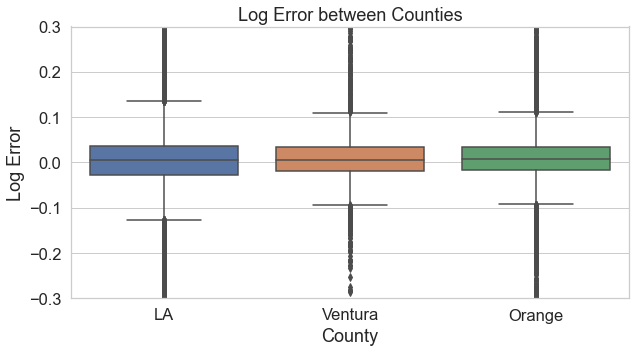

In [6]:
# split it out by county to get a more accurate depiction
# plot out the log error between each of the counties
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(10,5))
plt.ylim(-.3, .3) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.county, y=train.logerror)
plt.title('Log Error between Counties')
plt.xlabel('County')
plt.ylabel('Log Error')
plt.show()

- Visually, it seems that the average log error is about the same between each county, but LA county does have a larger lower quartile

### We wil run an Anova test to see if there is a more meaningful difference in the means
H0: There is no difference between the average log error of these counties.

H1: There is a difference between the average log error of at least one of these counties. 

In [7]:
#one-way anova test 
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.county == 'LA'], train.logerror[train.county == 'Orange'], train.logerror[train.county == 'Ventura'])
F, p

(12.350793385182836, 4.351737907478078e-06)

In [8]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')


We reject the null hypothesis


In [9]:
# we will test the same null hypothesis using the Kruskal- Wallis test in case the data wasn't normally distributed
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.county == 'LA'], train.logerror[train.county == 'Orange'], train.logerror[train.county == 'Ventura'])
H, p

(34.15811814394361, 3.825241765625664e-08)

In [10]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


<div class="alert alert-block alert-success">

Takeaway: 
    While there doesn't seem to be a difference that we can see in our visualization, there is a statistical difference between the logerror of each county

<div class="alert alert-block alert-warning">
    
# Question 2: Is there a relationship between log error and the month that the property was sold?

In [11]:
# before getting started, lets see the number of sales per month
train.month.value_counts().sort_index()

1    2381
2    2079
3    3038
4    2968
5    3548
6    3894
7    3191
8    3387
9    1540
Name: month, dtype: int64

<div class="alert alert-block alert-warning">
- We can see that more people are buying towards the middle of the year

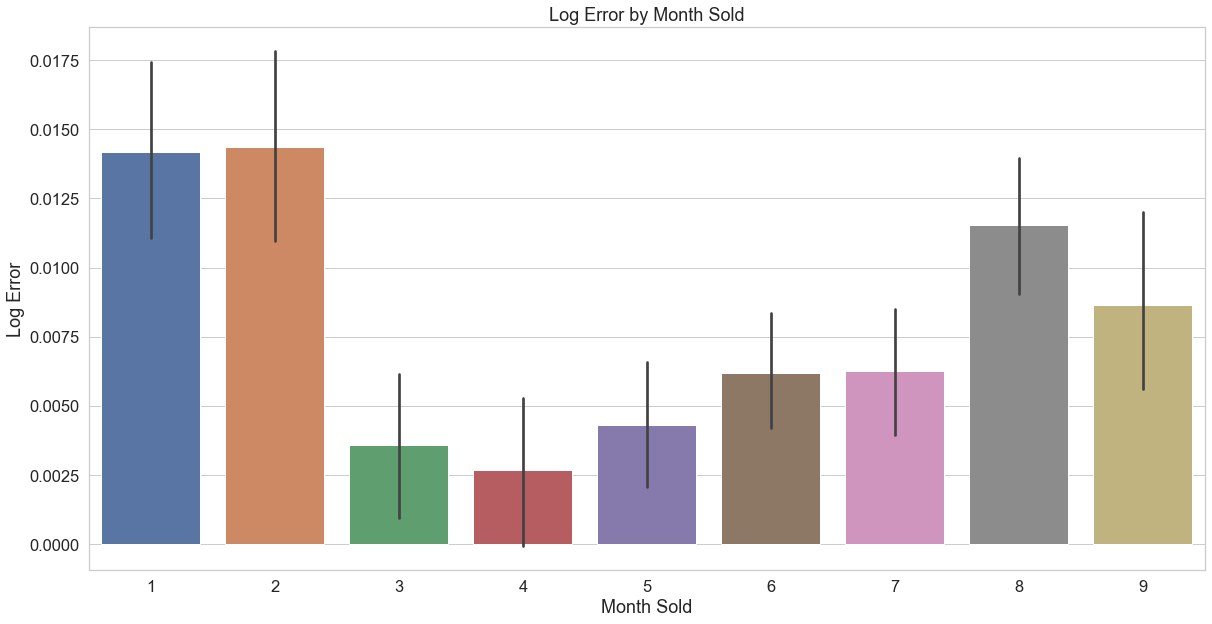

In [12]:
# Bar plot for month and log error
plt.figure(figsize=(20,10))
sns.barplot(data=train, x=train.month, y= train.logerror)
plt.title('Log Error by Month Sold')
plt.xlabel('Month Sold')
plt.ylabel('Log Error')
plt.show()

- This plot, combined with the number of sales that we know from earlier, shows us that there could be a relationship between the number of sales made during a time frame and logerror.
- In the first, second, and nineth month, there were significantly less sales made and the logerror during those times seems, on average, to be a lot higher

### We will run a spearman's correlation test to verify
- H0: There is no relationship between month sold and the average log error

- H1: There is a relationship between month sold and log error

In [13]:
# running the spearmans r test for verification. 
f, p = stats.spearmanr(train.yearbuilt, train.logerror)

if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


<div class="alert alert-block alert-success">

Takeaway: We reject our null hypothesis and can conclude that there is a relationship between month sold and log error

<div class="alert alert-block alert-warning">

## Question 3: Is there a relationship between tax value dollar count and log error? 

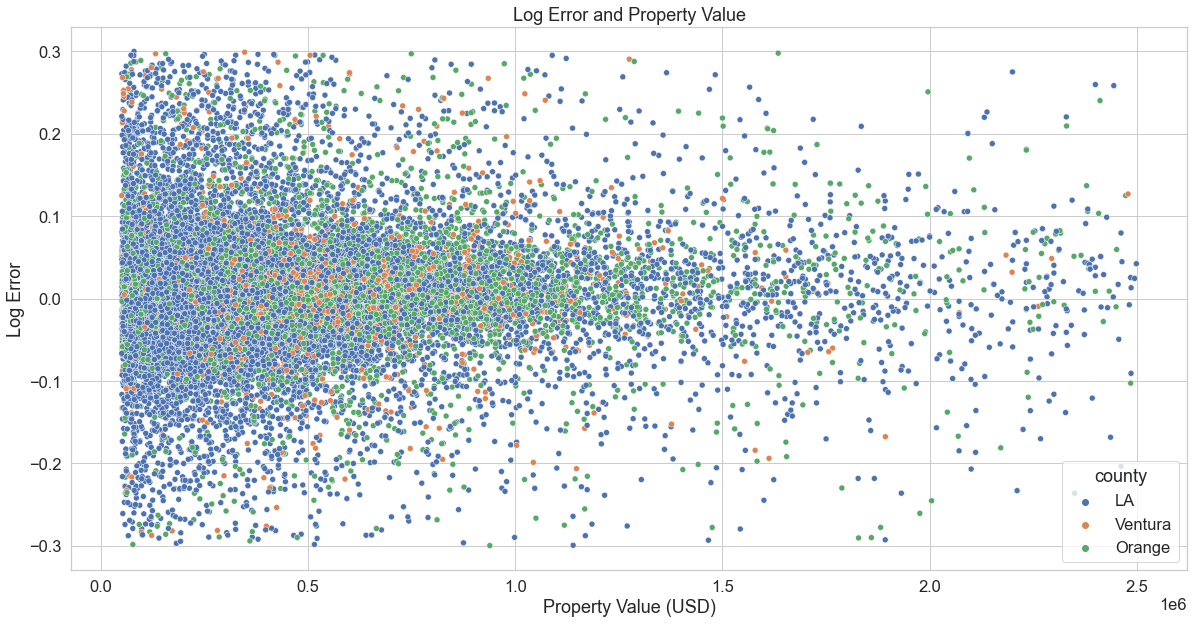

In [56]:
#scatter plot for taxvaluedollarcount and logerror, with a hue of county
plt.figure(figsize=(20,10))
sns.scatterplot(data=train, x=train.taxvaluedollarcnt, y= train.logerror, hue = 'county')
plt.title('Log Error and Property Value')
plt.xlabel('Property Value (USD)')
plt.ylabel('Log Error')
plt.show()

- It looks like a lot of the middle range value homes are sold in ventura and orange county, while LA county sells a lot of the more low cost AND high cost homes.
- log error looks to narrow towards zero the until about 1.5 million dollars, then seems to just go everywhere

### I will run a pearson r test to see if there is a relationship between log error and tax value dollar count

H0= There is no relationship between logerror and taxvaluedollarcnt.

H1= There is a relationship between logerror and taxvaluedollarcnt.

In [57]:
#pearson r statistical test to see if there is a relationship between the variables
corr, p = stats.pearsonr(train.logerror, train.taxvaluedollarcnt)
p

0.08058397572640491

In [16]:
if p < alpha:
    print ('I reject the null hypothesis.')
else:
        print('I accept the null hypothesis.')


I accept the null hypothesis.


<div class="alert alert-block alert-success">
Takeaway : We accept the null hypothesis, there is no relationship between log error and tax value dollar count

<div class="alert alert-block alert-warning">

# Question 4: Is there a relationship between the age of the property and log error?

Text(0.5, 1.0, 'Logerror and Age of Property')

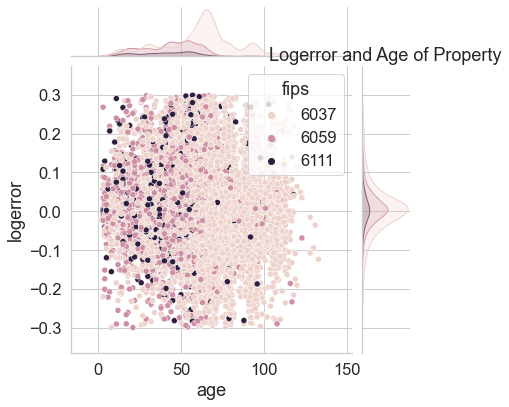

In [17]:
#jointplot of log error vs age with a hue of fips
sns.jointplot(x='age', y = 'logerror', hue = 'fips', data = train)
plt.xlabel('Age of Property')
plt.ylabel('Logerror')
plt.title('Logerror and Age of Property')

- Takeaway: There doesn't seem to be any immediate visual connection between logerror and age of the property.

### We will run a spearman's stat test to verify

- H0: There is no relationship between age of the property and the log error

- H1: There is a relationship between age of the property and log error

In [18]:
# running the spearmans r test for verification. 
f , p =stats.spearmanr(train.age, train.logerror)
f, p

(-0.04743715125267305, 1.906571013380094e-14)

In [19]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


<div class="alert alert-block alert-success">
- Takeaway: We can reject our null hypothesis that there is no relationship between age of the property and log error.

### Clustering the features that I have investigated to see if there are any meaningful clusters

In [44]:
# Creating my X values to use for clustering
X= train_s[['age', 'taxvaluedollarcnt', 'month', 'latitude','longitude']]
X1= validate_s[['age', 'taxvaluedollarcnt', 'month', 'latitude','longitude']]
X2= test_s[['age', 'taxvaluedollarcnt', 'month', 'latitude','longitude']]

In [47]:
#creating and fitting the KMeans model, then predicting
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

#storing the predicted cluster
train_s['cluster_value'] = kmeans.predict(X)
validate_s['cluster_value'] = kmeans.predict(X1)
test_s['cluster_value'] = kmeans.predict(X2)


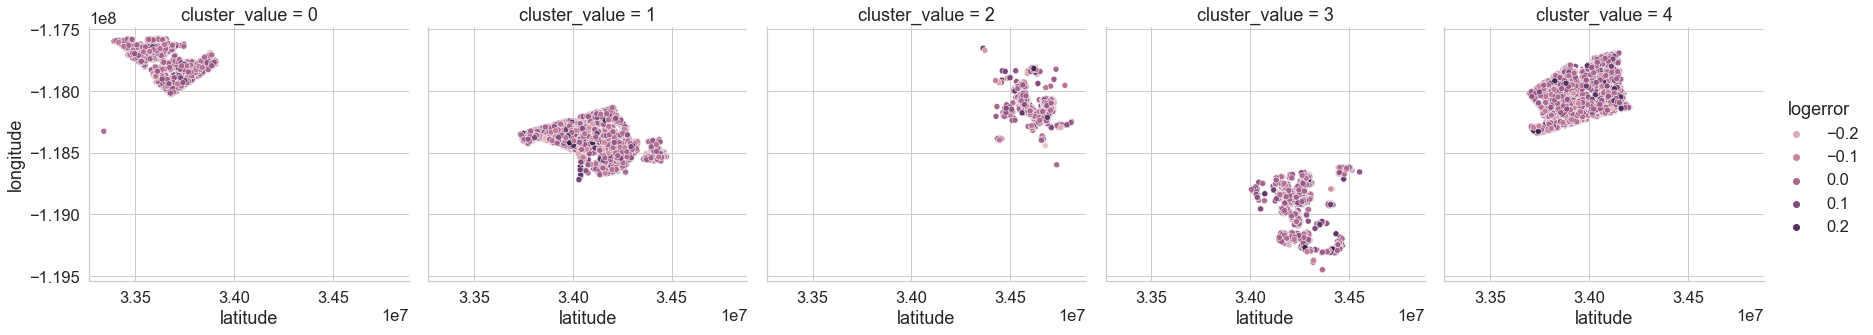

In [48]:
# Plotting results
sns.relplot(data=train_s, x='latitude', y='longitude', col='cluster_value', hue='logerror')

- no real meaningful clusters found 

In [49]:
# Creating my X values to use for clustering
X3= train_s[['month', 'latitude','longitude']]
X4= validate_s[['month', 'latitude','longitude']]
X5= test_s[['month', 'latitude','longitude']]

In [50]:
#creating and fitting the KMeans model, then predicting
kmeans = KMeans(n_clusters=3)
kmeans.fit(X3)

kmeans.predict(X3)

#storing the predicted cluster
train_s['cluster_value'] = kmeans.predict(X3)
validate_s['cluster_value'] = kmeans.predict(X4)
test_s['cluster_value'] = kmeans.predict(X5)

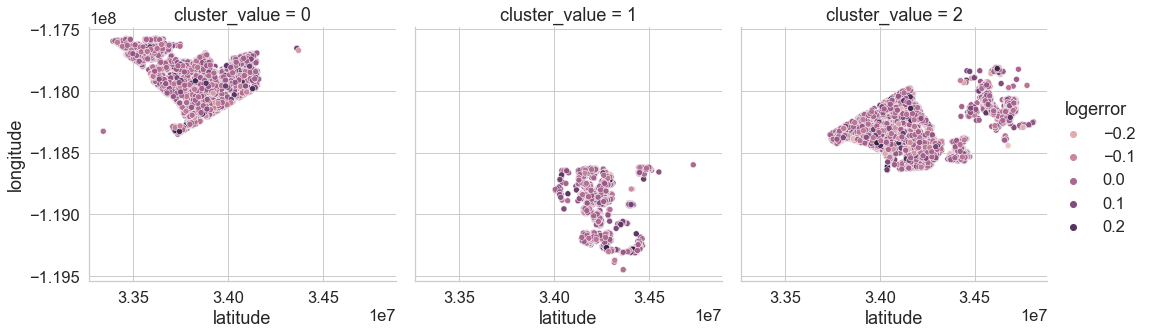

In [51]:
#plotting results
sns.relplot(data=train_s, x='latitude', y='longitude', col='cluster_value', hue='logerror')

In [52]:
# Creating my X values to use for clustering
X6= train_s[['taxvaluedollarcnt', 'month','age']]
X7= validate_s[['taxvaluedollarcnt', 'month','age']]
X8= test_s[['taxvaluedollarcnt', 'month','age']]

In [53]:
#creating and fitting the KMeans model, then predicting
kmeans = KMeans(n_clusters=3)
kmeans.fit(X3)

kmeans.predict(X3)

#storing the predicted cluster 
train_s['cluster_value'] = kmeans.predict(X3)
validate_s['cluster_value'] = kmeans.predict(X4)
test_s['cluster_value'] = kmeans.predict(X5)

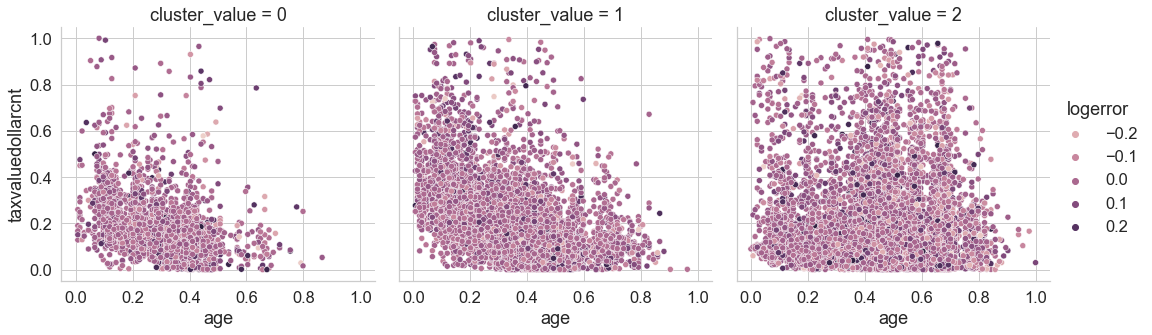

In [54]:
sns.relplot(data=train_s, x='age', y='taxvaluedollarcnt', col='cluster_value', hue='logerror')

<div class="alert alert-block alert-success">

# Exploration Conclusion:
- The location of the property, the age of the property, and when the property was purchased all have a relationship with log error
- There is no relationship between the tax value dollar count and the log error of the property
- There could be a relationship between log error and the amount of properties sold during a time frame, which I would like to further explore.
- No real clusters found between the variables that I paired together
<br>

<div class="alert alert-block alert-success">
    
# Modeling

In [30]:
# split into X variables and y target

# X is every column except log_error
X_train = train_s[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'age', 'month']]
# y is only log error, [[]] to keep as df and not series
y_train = train[['logerror']]

# repeat for validate and test
X_validate = validate_s[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'age', 'month']]
y_validate = validate[['logerror']]

X_test = test_s[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'age', 'month']]
y_test = test[['logerror']]



In [42]:
# Creating the baseline to mean of log_error
baseline = train.logerror.mean()

# calculating MSE with y_train (actual) and baseline (extended to same size as df)
baseline_mse = mean_squared_error(y_train, np.full(y_train.shape, baseline))
baseline_rmse = baseline_mse**1/2

print('The Baseline is:' , round(baseline, 5))
print('The Baseline Mean Squared Error:', round(baseline_mse,5))
print('The Baseline Root Mean Squared Error:', round(baseline_rmse,5))

The Baseline is: 0.00747
The Baseline Mean Squared Error: 0.00107
The Baseline Root Mean Squared Error: 0.00053


### Polynomial Model

In [58]:
#Polynomial model 
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [33]:
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2, y_train.logerror)

# train
y_train['logerror_poly'] = lm2.predict(X_train_degree2)

# get my rmse value for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_poly)**(1/2)

# validate
y_validate['logerror_poly'] = lm2.predict(X_validate_degree2)

# get my rmse rmse for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_poly)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.07177107356857018 
Validation/Out-of-Sample:  0.07152950577927578


<div class="alert alert-block alert-warning">
- This model is beat by baseline with a validation of .0715

### Linear Regression

In [34]:
# create the model
lm = LinearRegression()

#fit the model
lm.fit(X_train, y_train.logerror)

# train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# get rmse for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# get rmse for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.0720552235477181 
Validation/Out-of-Sample:  0.07168277165448593


<div class="alert alert-block alert-warning">
- This model is beat by baseline with a validation of .0716, and does slightly worse than the polynomial regression model

## LassoLars

In [35]:
# create the model
lars = LassoLars(alpha=1.0)

# fit the model
lars.fit(X_train, y_train.logerror)

# train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# get rmse for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# get rmse for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  0.07228923976506361 
Validation/Out-of-Sample:  0.07179734501862543


<div class="alert alert-block alert-warning">
- This model is beat by baseline with a validation of .0718, and is also beat by the polynomial regression model

## TweedieRegressor(GLM)

In [36]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0.1)

# fit the model to the training data. I must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0.1\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0.1
Training/In-Sample:  0.07225609771830767 
Validation/Out-of-Sample:  0.07174646013984584


<div class="alert alert-block alert-warning">
- This model is beat by baseline with a validation of .0717, and is still just slightly beat by our polynomial model 

<div class="alert alert-block alert-success">
    
## Our Polynomial Model with a degree of 2 gave us the best validation with a .0715, so we will use this for our test 

In [37]:
# test the model
y_test['logerror_poly'] = lm2.predict(X_test_degree2)

# get rmse value for test
rmse_test_poly = mean_squared_error(y_test.logerror, y_test.logerror_poly)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest: ", rmse_test_poly)

RMSE for Polynomial Model, degrees=2
Test:  0.07028632043133454


<div class="alert alert-block alert-success">

### Takeaways: 

My Polynomial model with a depth of 2 was my best model by just a little, with a test sample coming back at .0703, but it still did not beat the baseline of .002.
<br>

# Conclusions and Moving Forward

<div class="alert alert-block alert-success">

### Key Takeaways
    
- The the factors that seem to most contribute to log error are the location of the property, the age of the property, and when the property was sold
 
- There seems to be an inverse relationship between the number of properties sold during a specific time and log error
     - i.e. the more properties that are sold the lower the log error
    
- My polynomial model performed the best out of the models that were given, but it still did not beat baseline

### With more time
    
- Further investigate the relationship between the number of properties sold during a time frame and the log error. 
    
- Adjust the variables in my models to see if I can make a model that:
    - beats my current polynomial model
    - improves the current model that we have 
    
### Recommendations
    
- Focus on the slower months of the year and try to find a way to reduce log error during those months first
    
- Consider pursuing models that focus on smaller geographic areas, like zip codes, instead of one large model that covers a large variety factors. 
    
- Ensure that data is entered into columns to prevent an excess of null values, which is seen in many columns
<br>